In this notebook, we will see how to generate insights from text data using NLP techniques. This kernel will be divided into the following parts.

1. Basic Pre-Processing
2. Rapid Automatic Keyword Extraction
3. Flashtext
4. Sentiment Word Extract
5. Text Rank

** These techniques most useful in the Key topics extraction and contextual sentiment in the product review

In [1]:
!pip install rake_nltk
!pip install pytextrank

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=27a6bb07054e1545bf68d3393b86c138986841a228a9a4370337ab1303cf338c
  Stored in directory: /root/.cache/pip/wheels/ad/4f/6b/a5e7778f5c084d8b7c2c5fe9d37eb806f5ff5fee5e8ee17342
Successfully built rake-nltk


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import re
import os
import spacy

#https://pypi.org/project/rake-nltk/
import rake_nltk
from rake_nltk import Metric, Rake
r = Rake()

#https://github.com/vi3k6i5/flashtext
from flashtext import KeywordProcessor

#TextRank
#https://towardsdatascience.com/textrank-for-keyword-extraction-by-python-c0bae21bcec0
import pytextrank

#Spacy
import spacy
nlp = spacy.load('en')
import spacy
nlp = spacy.load('en_core_web_sm')


#Bar
from tqdm import tqdm, tqdm_pandas
tqdm(tqdm())
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [3]:
data_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
print("Data shape = ",data_train.shape)
data_train.head(2)

Data shape =  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [4]:
data_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print("Data shape = ",data_train.shape)
data_train.head(2)

Data shape =  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


# Basic Pre-Processing

In [5]:
### Own Stop words
own_stop_word = ['i','we','are','and']
### Spacy Lemma 
def spacy_lemma_text(text):
    doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in own_stop_word ]
    tokens = ' '.join(tokens)
    return tokens

### Remove URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [6]:
data_train['text_clean'] = data_train['text'].apply(remove_URL)
data_train['text_clean'] = data_train['text'].apply(spacy_lemma_text)
print("Train Cleaning - Done")
data_test['text_clean'] = data_test['text'].apply(remove_URL)
data_test['text_clean'] = data_test['text'].apply(spacy_lemma_text)
print("Test Cleaning - Done")

Train Cleaning - Done
Test Cleaning - Done


# Rapid Automatic Keyword Extraction

**RAKE** short for Rapid Automatic Keyword Extraction algorithm, is a domain independent keyword extraction algorithm which tries to determine key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text.
* This is used for extracting and ranking the keywords/phrases out of a document without any other context except for the document 
itself.

In [7]:
Rake_keywords = []
r = Rake()
r = Rake(min_length=2, max_length=4)

for text in data_train['text_clean']:
      r.extract_keywords_from_text(text)
      r.get_ranked_phrases()
      Rake_keywords.append(r.get_ranked_phrases())  

data_train['Rake_Keyword'] = Rake_keywords        

In [8]:
Rake_keywords = []
r = Rake()
r = Rake(min_length=2, max_length=4)

for text in data_test['text_clean']:
      r.extract_keywords_from_text(text)
      r.get_ranked_phrases()
      Rake_keywords.append(r.get_ranked_phrases())  

data_test['Rake_Keyword'] = Rake_keywords     

> # Flashtext 

 This is used to replace keywords in sentences or extract keywords from sentences.Below are the Usage
*  Extract keywords
*  Replace keywords
*  Case Sensitive 
*  Span of keywords extracted
*  Get Extra information with keywords extracted
*  No clean name for Keywords
*  Add Multiple Keywords simultaneously
*  To Remove keywords
*  To check Number of terms in KeywordProcessor
*  To check if term is present in KeywordProcessor
*  Get all keywords in dictionary
 

In [9]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor(case_sensitive=False)

In [10]:
keyword_dict = {
    "excaltor": ["exclators", "excaltors"]}
keyword_processor.add_keywords_from_dict(keyword_dict)

## You can add the important key word i.e prouduct name , features , payments

In [11]:
Flash_keywords = []
for i in data_train['text_clean']:
    keyword_processor.extract_keywords(i)
    Flash_keywords.append(keyword_processor.extract_keywords(i))
    
data_train['Flash_Keyword'] = Flash_keywords    

In [12]:
Flash_keywords = []
for i in data_test['text_clean']:
    keyword_processor.extract_keywords(i)
    Flash_keywords.append(keyword_processor.extract_keywords(i))
    
data_test['Flash_Keyword'] = Flash_keywords        

# Aspect-Based Opinion Mining

Aspect-Based Opinion Mining is to extract product's aspects and the associated user opinions from the user text review

In [13]:
aspect_terms = []
for review in nlp.pipe(data_train.text_clean):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
    
data_train['Aspect_Terms'] = aspect_terms    

In [14]:
aspect_terms = []
for review in nlp.pipe(data_test.text_clean):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
    
data_test['Aspect_Terms'] = aspect_terms    

# Sentiment Word Extract

Key topics extraction and contextual sentiment of users’ reviews/contents

In [15]:
sentiment_terms = []

for review in nlp.pipe(data_train['text_clean']):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')  
            
data_train['Sentiment_terms'] = sentiment_terms            

In [16]:
sentiment_terms = []

for review in nlp.pipe(data_test['text_clean']):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')  
            
data_test['Sentiment_terms'] = sentiment_terms            

# Text Rank

PyTextRank is a Python implementation of TextRank as a spaCy extension, used to:

*     Extract the top-ranked phrases from text documents
*     Infer links from unstructured text into structured data
*     Run extractive summarization of text documents


In [17]:
import spacy
import pytextrank
nlp = spacy.load('en_core_web_sm')
tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name='textrank', last=True)

In [18]:
pytext_key = []

for text in data_train['text_clean']:
    text = nlp(text)
    t = text._.phrases
    pytext_key.append(t)
    
data_train['Pytextrank_keyword'] = pytext_key    

In [19]:
pytext_key = []

for text in data_test['text_clean']:
    text = nlp(text)
    t = text._.phrases
    pytext_key.append(t)
    
data_test['Pytextrank_keyword'] = pytext_key    

# Here is the Output 

In [20]:
data_train.head()

,id,keyword,location,text,target,text_clean,Rake_Keyword,Flash_Keyword,Aspect_Terms,Sentiment_terms,Pytextrank_keyword
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed be the reason of this # earthquake may al...,[earthquake may allah forgive],[],reason earthquake,forgive,"[allah, deed, this # earthquake, the reason]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask . canada,[],[],fire sask,,"[la ronge sask, forest fire, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resident ask to ' shelter in place ' be be...,"[resident ask, place order]",[],resident shelter place officer evacuation shel...,ask notify expect,"[shelter, place order, place, officer, no othe..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfire evacuation or...","[wildfire evacuation order, 000 people receive]",[],people order,receive,"[# wildfire evacuation order, california, 13,0..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get send this photo from ruby # alaska as...,"[wildfire pour, get send]",[],photo smoke school,send pour,"[smoke, ruby # alaska, this photo, a school]"


In [21]:
data_test.head()

,id,keyword,location,text,text_clean,Rake_Keyword,Flash_Keyword,Aspect_Terms,Sentiment_terms,Pytextrank_keyword
0,0,NaN,NaN,Just happened a terrible car crash,just happen a terrible car crash,[terrible car crash],[],crash,happen terrible,[a terrible car crash]
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","hear about # earthquake be different city , st...","[stay safe everyone, different city]",[],earthquake city,hear different stay safe,"[different city, safe everyone, about # earthq..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there be a forest fire at spot pond , geese be...","[spot pond, forest fire, flee across]",[],fire street,flee save,"[spot pond, geese, a forest fire, the street]"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting . # spokane # wildfire,[apocalypse lighting],[],lighting spokane,,"[# spokane #, apocalypse lighting]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 in china taiwan,"[typhoon soudelor kill 28, china taiwan]",[],soudelor,kill,"[typhoon soudelor, china, taiwan, 28]"


# Sentence Lenght Analysis

In [22]:
from IPython.core.display import display, HTML
import plotly.graph_objects as go
df = data_train.copy()
df['length'] = df['text_clean'].apply(len)

In [23]:
data = [
    go.Box(
        y=df[df['target']==1]['length'],
        name='Real'
    ),
    go.Box(
        y=df[df['target']==0]['length'],
        name='Not'
    ),

]
layout = go.Layout(
    title = 'Target Class Vs Comment Lenght (After Cleaning)'
)
fig = go.Figure(data=data, layout=layout)
fig.show()

# PCA Analysis 

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

import seaborn as sns

def get_tf_idf(df, text_field ='text', sent_field="airline_sentiment"):
    # creating bag of words freq counts post tokenizing
    count_vect = CountVectorizer()
    X_bog = count_vect.fit_transform(df[text_field])

    # creating the tf-idf vectors. 
    tf_transformer = TfidfTransformer(norm='l2')
    X = tf_transformer.fit_transform(X_bog)
    y = df[sent_field]
    return X, y

## PCA Analysis - Pre Processed Text

Text(0.5, 1.0, 'Text Vs Target')

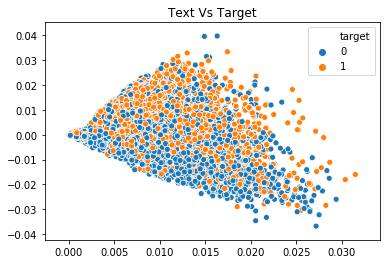

In [25]:
X, y = get_tf_idf(df, "text_clean", "target")
pca = TruncatedSVD(n_components=2, n_iter=7, random_state=4)
pca.fit_transform(X.T)
ax1 = sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=y)
plt.title("Text Vs Target")

## PCA Analysis - Aspect Terms

Text(0.5, 1.0, 'Aspect Terms Vs Target')

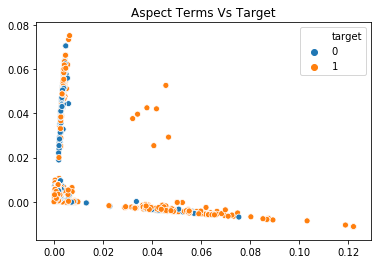

In [26]:
X, y = get_tf_idf(df, "Aspect_Terms", "target")
pca = TruncatedSVD(n_components=2, n_iter=7, random_state=4)
pca.fit_transform(X.T)
ax2 = sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=y)
plt.title("Aspect Terms Vs Target")

## PCA Analysis - Sentiment Terms

Text(0.5, 1.0, 'Sentiment Terms Vs Target')

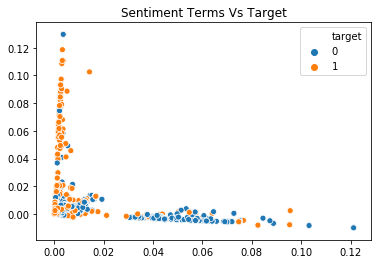

In [27]:
X, y = get_tf_idf(df, "Sentiment_terms", "target")
pca = TruncatedSVD(n_components=2, n_iter=7, random_state=4)
pca.fit_transform(X.T)
ax3 = sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=y)
plt.title("Sentiment Terms Vs Target")

In [28]:
print ("Working on the Aspect Based Extraction....:) ")

Working on the Aspect Based Extraction....:) 
